In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [12]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)
print(ratings.shape)
print(ratings[:,0].getnnz())
print(ratings)

number of items: 1682, number of users: 943
(1682, 943)
271
  (0, 1)	4.0
  (0, 4)	4.0
  (0, 5)	4.0
  (0, 9)	4.0
  (0, 12)	3.0
  (0, 14)	1.0
  (0, 15)	5.0
  (0, 16)	4.0
  (0, 17)	5.0
  (0, 19)	3.0
  (0, 20)	5.0
  (0, 22)	5.0
  (0, 24)	5.0
  (0, 25)	3.0
  (0, 37)	5.0
  (0, 40)	4.0
  (0, 41)	5.0
  (0, 42)	5.0
  (0, 43)	4.0
  (0, 44)	5.0
  (0, 48)	2.0
  (0, 53)	4.0
  (0, 55)	4.0
  (0, 56)	5.0
  (0, 57)	5.0
  (0, 58)	2.0
  (0, 61)	2.0
  (0, 62)	3.0
  (0, 63)	4.0
  (0, 64)	3.0
  (0, 65)	3.0
  (0, 66)	3.0
  (0, 69)	4.0
  (0, 71)	4.0
  (0, 72)	2.0
  (0, 74)	4.0
  (0, 76)	5.0
  (0, 78)	4.0
  (0, 80)	4.0
  (0, 81)	4.0
  (0, 82)	4.0
  (0, 83)	2.0
  (0, 88)	5.0
  (0, 91)	4.0
  (0, 92)	5.0
  (0, 93)	4.0
  (0, 94)	5.0
  (0, 95)	5.0
  (0, 96)	4.0
  (0, 98)	4.0
  (0, 100)	3.0
  (0, 101)	3.0
  (0, 105)	4.0
  (0, 107)	4.0
  (0, 108)	4.0
  (0, 116)	4.0
  (0, 119)	4.0
  (0, 120)	4.0
  (0, 123)	3.0
  (0, 124)	4.0
  (0, 127)	4.0
  (0, 129)	5.0
  (0, 130)	4.0
  (0, 133)	5.0
  (0, 136)	3.0
  (0, 137)	4.0
  (0

### Plot the number of ratings per movie and user

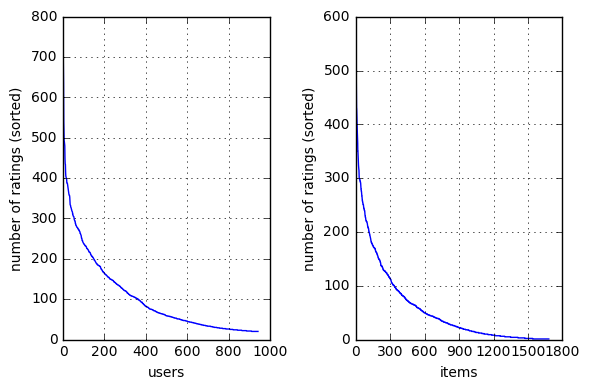

min # of items per user = 20, min # of users per item = 1.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    train=sp.lil_matrix(valid_ratings.shape)
    test=sp.lil_matrix(valid_ratings.shape)
    for item in range(valid_ratings.shape[0]):
        for user in range(valid_ratings.shape[1]):
            taken=np.random.randint(0,10)
            if taken==0:
                #test
                test[item,user]=valid_ratings[item,user]
            else:
                train[item,user]=valid_ratings[item,user]
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88373
Total number of nonzero elements in test data:9579


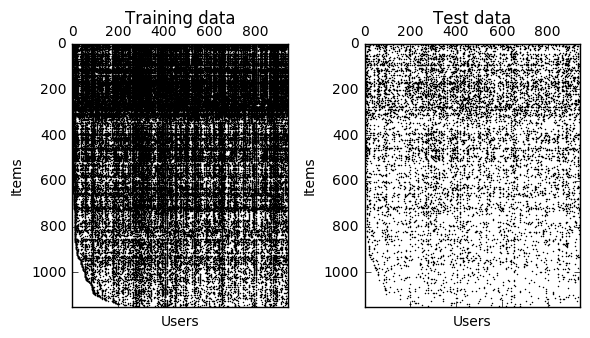

In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [6]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    indices_of_values_train=np.where(train.toarray()>0)
    indices_of_values_test=np.where(test.toarray()>0)
    return np.mean(train[indices_of_values_train]),np.mean(test[indices_of_values_test])
print(baseline_global_mean(train, test))

(3.5464112341976928, 3.5420189998957188)


### Use the user means as the prediction

In [7]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    def user_mean(data,data_name):
        data_arrayT=data.toarray().T
        user_means=[]
        for user in range(data_arrayT.shape[0]):
            user_i=np.where(data_arrayT[user]>0)[0]
            # Happens sometimes in test. When a user has no picked up ratings in test
            # (ex: he has 10 ratings, all of them went to train)
            if user_i.shape[0]==0:
                print("User ",user, " has no ratings in ", data_name)
                user_means.append(0)
            else:
                user_r=data_arrayT[user][user_i]
                user_means.append(np.mean(user_r))
        return user_means
    
    return user_mean(train,"Train data"),user_mean(test,"Test data")
baseline_user_mean(train, test)

User  52  has no ratings in  Test data
User  228  has no ratings in  Test data
User  265  has no ratings in  Test data
User  303  has no ratings in  Test data
User  399  has no ratings in  Test data
User  440  has no ratings in  Test data
User  443  has no ratings in  Test data
User  569  has no ratings in  Test data
User  661  has no ratings in  Test data
User  739  has no ratings in  Test data
User  741  has no ratings in  Test data
User  823  has no ratings in  Test data
User  840  has no ratings in  Test data


([3.6540084388185652,
  3.8148148148148149,
  2.7142857142857144,
  4.4090909090909092,
  2.9562499999999998,
  3.6470588235294117,
  3.9664804469273744,
  3.7777777777777777,
  4.2777777777777777,
  4.1975308641975309,
  3.4451219512195124,
  4.4468085106382977,
  3.179732313575526,
  4.1627906976744189,
  2.8888888888888888,
  4.2834645669291342,
  3.1153846153846154,
  3.9221311475409837,
  3.4705882352941178,
  3.1499999999999999,
  2.7565789473684212,
  3.4347826086956523,
  3.6423357664233578,
  4.2592592592592595,
  4.0588235294117645,
  2.9895833333333335,
  3.25,
  3.6944444444444446,
  3.6428571428571428,
  3.7749999999999999,
  3.9411764705882355,
  3.2424242424242422,
  3.6499999999999999,
  3.9411764705882355,
  3.1052631578947367,
  3.6666666666666665,
  3.6603773584905661,
  3.7572815533980584,
  3.75,
  2.7999999999999998,
  3.7346938775510203,
  3.7025316455696204,
  3.7064676616915424,
  3.6518518518518519,
  3.6222222222222222,
  4.0769230769230766,
  3.6666666666666

### Use the item means as the prediction

In [8]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    def item_mean(data,data_name):
        data_array=data.toarray()
        item_means=[]
        for item in range(data_array.shape[0]):
            item_i=np.where(data_array[item]>0)[0]
            # Happens sometimes in test. When a movies has no picked up ratings in test
            # (ex: it has 10 ratings, all of them went to train)
            if item_i.shape[0]==0:
                print("Item ",item, " has no ratings in ", data_name)
                item_means.append(0)
            else:
                item_r=data_array[item][item_i]
                item_means.append(np.mean(item_r))
        return item_means
    
    return item_mean(train,"Train data"),item_mean(test,"Test data")
    
baseline_item_mean(train, test)

Item  33  has no ratings in  Test data
Item  79  has no ratings in  Test data
Item  106  has no ratings in  Test data
Item  138  has no ratings in  Test data
Item  336  has no ratings in  Test data
Item  349  has no ratings in  Test data
Item  356  has no ratings in  Test data
Item  362  has no ratings in  Test data
Item  365  has no ratings in  Test data
Item  437  has no ratings in  Test data
Item  486  has no ratings in  Test data
Item  517  has no ratings in  Test data
Item  519  has no ratings in  Test data
Item  548  has no ratings in  Test data
Item  557  has no ratings in  Test data
Item  586  has no ratings in  Test data
Item  643  has no ratings in  Test data
Item  673  has no ratings in  Test data
Item  674  has no ratings in  Test data
Item  705  has no ratings in  Test data
Item  749  has no ratings in  Test data
Item  756  has no ratings in  Test data
Item  758  has no ratings in  Test data
Item  763  has no ratings in  Test data
Item  772  has no ratings in  Test data
It

([3.8585365853658535,
  3.2268907563025211,
  3.0,
  3.5392670157068062,
  3.3125,
  3.4782608695652173,
  3.7838616714697406,
  4.0101010101010104,
  3.8805970149253732,
  3.8441558441558441,
  3.8476190476190477,
  4.3729508196721314,
  3.3818181818181818,
  3.8924050632911391,
  3.8195488721804511,
  3.2105263157894739,
  3.072289156626506,
  2.5555555555555554,
  3.8888888888888888,
  3.3582089552238807,
  2.7702702702702702,
  4.1444866920152093,
  4.1005917159763312,
  3.4562499999999998,
  3.4646840148698885,
  3.4461538461538463,
  3.0377358490566038,
  3.9461538461538463,
  2.6699999999999999,
  4.0285714285714285,
  3.6546762589928057,
  3.7671232876712328,
  3.5542168674698793,
  2.1818181818181817,
  2.0833333333333335,
  3.0087719298245612,
  3.2875000000000001,
  2.8431372549019609,
  3.1428571428571428,
  3.7890625,
  3.0263157894736841,
  3.3648648648648649,
  4.0684931506849313,
  3.6400000000000001,
  3.5123966942148761,
  4.1121495327102799,
  3.2837837837837838,
  4

In [15]:
pred=train.toarray()
origin=test.toarray()
mean_global,_=baseline_global_mean(train,test)
mean_item,_=baseline_item_mean(train,test)
mean_user,_=baseline_user_mean(train,test)
mse_global=0
mse_item=0
mse_user=0
for item in range(pred.shape[0]):
    for user in range(pred.shape[1]):
        if(pred[item,user]==0 and origin[item,user]!=0):
            e=mean_global-origin[item,user]
            mse_global+=e*e
            e=mean_item[item]-origin[item,user]
            mse_item+=e*e
            e=mean_user[user]-origin[item,user]
            mse_user+=e*e
print(mse_global,mse_item,mse_user)

Item  33  has no ratings in  Test data
Item  79  has no ratings in  Test data
Item  106  has no ratings in  Test data
Item  138  has no ratings in  Test data
Item  336  has no ratings in  Test data
Item  349  has no ratings in  Test data
Item  356  has no ratings in  Test data
Item  362  has no ratings in  Test data
Item  365  has no ratings in  Test data
Item  437  has no ratings in  Test data
Item  486  has no ratings in  Test data
Item  517  has no ratings in  Test data
Item  519  has no ratings in  Test data
Item  548  has no ratings in  Test data
Item  557  has no ratings in  Test data
Item  586  has no ratings in  Test data
Item  643  has no ratings in  Test data
Item  673  has no ratings in  Test data
Item  674  has no ratings in  Test data
Item  705  has no ratings in  Test data
Item  749  has no ratings in  Test data
Item  756  has no ratings in  Test data
Item  758  has no ratings in  Test data
Item  763  has no ratings in  Test data
Item  772  has no ratings in  Test data
It

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [20]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    user_features=np.zeros([num_features,train.shape[1]])
    item_features=np.zeros([num_features,train.shape[0]])
    return user_features,item_features

Compute the cost by the method of matrix factorization.


In [21]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # calculate rmse (we only consider nonzero entries.)
    # ***************************************************
    pred=item_features.T @ user_features
    e=data-pred
    e=e*e
    return np.sqrt(np.sum(e[nz]))
    

In [ ]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        gradW=np.zeros(item_features.shape).T
        gradZ=np.zeros(user_features.shape).T
        for d, n in nz_train:
            gradW=np.zeros(item_features.shape).T
            gradZ=np.zeros(user_features.shape).T
            cst=-(train[d,n]-(item_features.T @ user_features)[d,n])
            gradW[d]=cst*user_features[:,n]
            gradZ[n]=cst*item_features[:,d]
            item_features=item_features+gradW.T
            user_features=user_features+gradZ.T
        
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)
    # ***************************************************
    # TODO
    # evaluate the test error.
    # ***************************************************
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    raise NotImplementedError

matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...


### Learn the Matrix Factorization using Alternating Least Squares

In [ ]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return user feature.
    # ***************************************************
    raise NotImplementedError

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return item feature.
    # ***************************************************
    raise NotImplementedError

In [ ]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # start you ALS-WR algorithm.
    # ***************************************************
    raise NotImplementedError

ALS(train, test)